In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, regularizers
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError                         #Sum of all Squared differences
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import  load_model

In [12]:
energy_df = pd.read_csv('Einsteiger Genießer.csv', sep=';', decimal=',')
energy_df['Time'] = pd.to_datetime(energy_df['Time'], format='%d.%m.%Y %H:%M')
timestamp_s = energy_df['Time'].map(pd.Timestamp.timestamp)
energy_df

,Electricity.Timestep,Time,Sum [kWh]
0,0,2016-01-01 00:00:00,0.00203968137295407
1,1,2016-01-01 00:01:00,0.00198002204725158
2,2,2016-01-01 00:02:00,0.00198569007313044
3,3,2016-01-01 00:03:00,0.0019885457127341
4,4,2016-01-01 00:04:00,0.00198097807214676
...,...,...,...
527035,527035,2016-12-31 23:55:00,0.00222233953122138
527036,527036,2016-12-31 23:56:00,0.00251202240082651
527037,527037,2016-12-31 23:57:00,0.00281460979360641
527038,527038,2016-12-31 23:58:00,0.00271012354349403


In [13]:
day = 24*60*60
year = (365.2425)*day
hour = 60*60

#Sinus/Cos hinzufügen
energy_df['hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
energy_df['hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
energy_df['Day sin'] = np.sin(timestamp_s * ( 2* np.pi / day))
energy_df['Day cos'] = np.cos(timestamp_s * (2* np.pi / day))
energy_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
energy_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#Wochentag hinzufügen
energy_df.index=pd.to_datetime(energy_df['Time'],format='%d.%m.%Y %H:%M')
energy_df['wochentag']=energy_df['Time'].dt.dayofweek
energy_df

,Electricity.Timestep,Time,Sum [kWh],hour sin,hour cos,Day sin,Day cos,Year sin,Year cos,wochentag
Time,,,,,,,,,,
2016-01-01 00:00:00,0,2016-01-01 00:00:00,0.00203968137295407,1.990413e-10,1.000000,-1.407890e-12,1.000000,-0.002666,0.999996,4
2016-01-01 00:01:00,1,2016-01-01 00:01:00,0.00198002204725158,1.045285e-01,0.994522,4.363309e-03,0.999990,-0.002654,0.999996,4
2016-01-01 00:02:00,2,2016-01-01 00:02:00,0.00198569007313044,2.079117e-01,0.978148,8.726535e-03,0.999962,-0.002643,0.999997,4
2016-01-01 00:03:00,3,2016-01-01 00:03:00,0.0019885457127341,3.090170e-01,0.951057,1.308960e-02,0.999914,-0.002631,0.999997,4
2016-01-01 00:04:00,4,2016-01-01 00:04:00,0.00198097807214676,4.067366e-01,0.913545,1.745241e-02,0.999848,-0.002619,0.999997,4
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:55:00,527035,2016-12-31 23:55:00,0.00222233953122138,-5.000000e-01,0.866025,-2.181489e-02,0.999762,0.010305,0.999947,5
2016-12-31 23:56:00,527036,2016-12-31 23:56:00,0.00251202240082651,-4.067366e-01,0.913545,-1.745241e-02,0.999848,0.010317,0.999947,5
2016-12-31 23:57:00,527037,2016-12-31 23:57:00,0.00281460979360641,-3.090170e-01,0.951057,-1.308960e-02,0.999914,0.010329,0.999947,5


<function matplotlib.pyplot.show(close=None, block=None)>

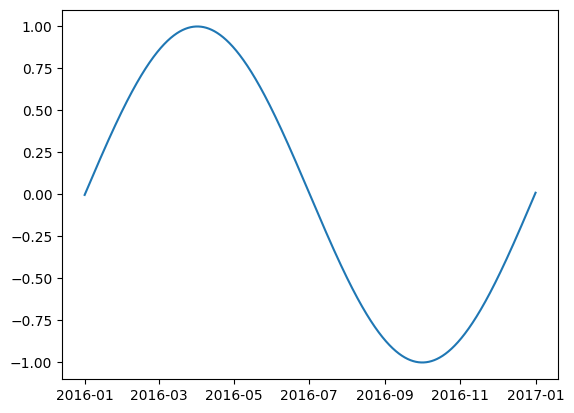

In [14]:
#Plotten zum Test mit allen Spalten, zum Eingrenzen [:1000]
plt.plot(energy_df['Year sin'])
plt.show

In [15]:
# Konvertiere die 'Sum [kWh]' Spalte in numerischen Typ
energy_df['Sum [kWh]'] = pd.to_numeric(energy_df['Sum [kWh]'], errors='coerce')



# Überprüfe die Datentypen
print(energy_df.dtypes)

Electricity.Timestep             int64
Time                    datetime64[ns]
Sum [kWh]                      float64
hour sin                       float64
hour cos                       float64
Day sin                        float64
Day cos                        float64
Year sin                       float64
Year cos                       float64
wochentag                        int32
dtype: object


In [16]:
#Prepare normalisation
max_sum_kWh =energy_df['Sum [kWh]'].max()
print(max_sum_kWh)

0.149508843670478


In [17]:
#Normalisieren
energy_df['Sum [kWh]'] = energy_df['Sum [kWh]'] / max_sum_kWh

#Datentyp umwandeln
energy_df['Sum [kWh]'] = energy_df['Sum [kWh]'].astype(float)

#Durchschnittlicherverbrauch pro WochenTag und hinzufügen  in Dataframe
average_consumption_by_weekday = energy_df.groupby('wochentag')['Sum [kWh]'].mean()
energy_df['Average Consumption Weekday'] = energy_df['wochentag'].map(average_consumption_by_weekday)

#Durchschnittlicherverbrauch pro Stunde
average_consumption_by_hour = energy_df.groupby('hour sin')['Sum [kWh]'].mean()
energy_df['Average Consumption hour sin'] = energy_df['hour sin'].map(average_consumption_by_hour)


#Spalten löschen
columns_to_drop= ['Time','wochentag','Electricity.Timestep'] 
energy_df=energy_df.drop(columns_to_drop, axis=1)

energy_df

,Sum [kWh],hour sin,hour cos,Day sin,Day cos,Year sin,Year cos,Average Consumption Weekday,Average Consumption hour sin
Time,,,,,,,,,
2016-01-01 00:00:00,0.013643,1.990413e-10,1.000000,-1.407890e-12,1.000000,-0.002666,0.999996,0.033676,0.013643
2016-01-01 00:01:00,0.013244,1.045285e-01,0.994522,4.363309e-03,0.999990,-0.002654,0.999996,0.033676,0.013244
2016-01-01 00:02:00,0.013281,2.079117e-01,0.978148,8.726535e-03,0.999962,-0.002643,0.999997,0.033676,0.013281
2016-01-01 00:03:00,0.013301,3.090170e-01,0.951057,1.308960e-02,0.999914,-0.002631,0.999997,0.033676,0.013301
2016-01-01 00:04:00,0.013250,4.067366e-01,0.913545,1.745241e-02,0.999848,-0.002619,0.999997,0.033676,0.013250
...,...,...,...,...,...,...,...,...,...
2016-12-31 23:55:00,0.014864,-5.000000e-01,0.866025,-2.181489e-02,0.999762,0.010305,0.999947,0.044425,0.014864
2016-12-31 23:56:00,0.016802,-4.067366e-01,0.913545,-1.745241e-02,0.999848,0.010317,0.999947,0.044425,0.016802
2016-12-31 23:57:00,0.018826,-3.090170e-01,0.951057,-1.308960e-02,0.999914,0.010329,0.999947,0.044425,0.018826


In [18]:
# Aufteilung in Features und Labels
X = energy_df[['Sum [kWh]','Day sin', 'Day cos', 'Year sin', 'Year cos', 'Average Consumption Weekday','Average Consumption hour sin']]        #Wenn man Stromverbrauch rauslässt trotzdem gute Ergebnisse ,'temperatur_2019'
y = energy_df['Sum [kWh]']

# Normierung der Daten (z.B. Min-Max-Skalierung)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Sequenzbildung
sequence_length = 100                                                                                                           #Beispiel: Sequenzen von 10 aufeinander folgenden Zeitschritten
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - sequence_length):    
   X_sequences.append(X_scaled[i:i+sequence_length, :])
   y_sequences.append(y.iloc[i+sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)
#Aufteilung in 30 Test 
# Festlegung der Größe für Training und Test
train_size = int(0.95 * len(X_sequences))
test_size = 2
val_size = len(X_sequences) - train_size - test_size

# Aufteilung in Trainings-, Validierungs- und Testdatensätze
X_train = X_sequences[:train_size]
y_train = y_sequences[:train_size]

X_val = X_sequences[train_size:train_size+val_size]
y_val = y_sequences[train_size:train_size+val_size]

X_test = X_sequences[train_size+val_size:train_size+val_size+test_size]
y_test = y_sequences[train_size+val_size:train_size+val_size+test_size]


# Überprüfen der Shape der Datensätze
print("Trainingsdaten:", X_train.shape, y_train.shape)
print("Validierungsdaten:", X_val.shape, y_val.shape)
print("Testdaten:", X_test.shape, y_test.shape)

Trainingsdaten: (500593, 100, 7) (500593,)
Validierungsdaten: (26345, 100, 7) (26345,)
Testdaten: (2, 100, 7) (2,)


In [19]:
#Funktion Definieren, sodass gesamte Spalte betrachtet und Stromverbrauch Ausgangswert
window_size = sequence_length


def df_to_X_y1(df, window_size=window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]            
    X.append(row)
    label = df_as_np[i+window_size][0]                      
    y.append(label)
  return np.array(X), np.array(y)

In [24]:
model_gen_lstm=Sequential()
#7 Timestamps/Windowsize wird nicht besser mit mehr Windows  11 relevante Variablen
model_gen_lstm.add(InputLayer(input_shape=(window_size,7)))  
model_gen_lstm.add(LSTM(100, return_sequences=True))
model_gen_lstm.add(LSTM(50))
model_gen_lstm.add(Dense(16))
model_gen_lstm.add(Dense(8, 'relu'))                       # Hochskalieren= Anzahl der Neuronen  erhöhen
# Ausgabewerte  1
model_gen_lstm.add(Dense(1,'linear'))
model_gen_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 100)          43200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 16)                816       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 74361 (290.47 KB)
Trainable params: 74361 (290.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Verzeichnis für das Modell erstellen
model_gen_lstm_save_path = r'C:\Users\Tobi\Desktop\Uni\Bachaelorarbeit\Projekte\Tensorflow 2.0\Model CP'
if not os.path.exists(model_gen_lstm_save_path):
    os.makedirs(model_gen_lstm_save_path)

In [26]:
# ModelCheckpoint Callback erstellen
checkpoint_filepath = os.path.join(model_gen_lstm_save_path, 'model_gen_lstm_checkpoint.h5')
cp = ModelCheckpoint(checkpoint_filepath, save_best_only=True)

In [27]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model_gen_lstm.compile(optimizer=optimizer, loss="MSE", metrics=["MAE"])
model_gen_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])


Epoch 1/10


2023-11-30 14:27:22.873766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 14:27:23.165078: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdbc8214700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 14:27:23.165103: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-11-30 14:27:23.169588: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 14:27:23.228760: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15644/15644 [==============================] - 198s 13ms/step - loss: 9.8788e-04 - MAE: 0.0124 - val_loss: 6.8583e-04 - val_MAE: 0.0142
Epoch 2/10
   10/15644 [..............................] - ETA: 3:16 - loss: 8.4361e-04 - MAE: 0.0099

/home/tobias/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15644/15644 [==============================] - 196s 13ms/step - loss: 6.9921e-04 - MAE: 0.0095 - val_loss: 6.0850e-04 - val_MAE: 0.0086
Epoch 3/10
15644/15644 [==============================] - 189s 12ms/step - loss: 6.6461e-04 - MAE: 0.0091 - val_loss: 5.8282e-04 - val_MAE: 0.0079
Epoch 4/10
15644/15644 [==============================] - 185s 12ms/step - loss: 6.4115e-04 - MAE: 0.0088 - val_loss: 5.6375e-04 - val_MAE: 0.0097
Epoch 5/10
15644/15644 [==============================] - 190s 12ms/step - loss: 6.2336e-04 - MAE: 0.0086 - val_loss: 5.3921e-04 - val_MAE: 0.0092
Epoch 6/10
15644/15644 [==============================] - 189s 12ms/step - loss: 5.9515e-04 - MAE: 0.0083 - val_loss: 5.4340e-04 - val_MAE: 0.0112
Epoch 7/10
15644/15644 [==============================] - 188s 12ms/step - loss: 5.5740e-04 - MAE: 0.0080 - val_loss: 4.8767e-04 - val_MAE: 0.0080
Epoch 8/10
15644/15644 [==============================] - 188s 12ms/step - loss: 5.3522e-04 - MAE: 0.0076 - val_loss: 4.7051e-04 

In [28]:
# Modell speichern 

model_gen_lstm.save(os.path.join(model_gen_lstm_save_path, 'my_model_gen_lstm.h5'))


In [29]:
# Modell wieder abrufen
loaded_model_gen_lstm = load_model(os.path.join(model_gen_lstm_save_path, 'my_model_gen_lstm.h5'))


15644/15644 [==============================] - 76s 5ms/step


,Train Predictions,Actuals
Time,,
2016-01-01 00:00:00,0.000212,0.000692
2016-01-01 00:01:00,0.000361,0.000720
2016-01-01 00:02:00,0.000370,0.000740
2016-01-01 00:03:00,0.000421,0.000706
2016-01-01 00:04:00,0.000444,0.000740
...,...,...
2016-12-13 15:08:00,0.004595,0.003896
2016-12-13 15:09:00,0.004308,0.004198
2016-12-13 15:10:00,0.004421,0.004703


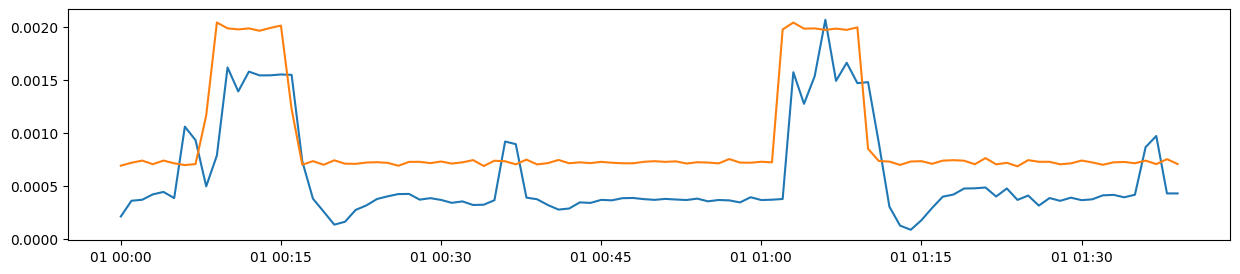

In [31]:
#Training anzeigen

train_predictions =model_gen_lstm.predict(X_train).flatten() #Vektor of Predicitions, flatten=> ohne inner Brackets  , nicht extra train_predictions1 da sonst nicht für nächste Modelle angewandt
y_train=y_train.ravel() 
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
# Rückgängig machen der Normalisierung
train_results['Train Predictions'] = train_results['Train Predictions'] * max_sum_kWh
train_results['Actuals'] = train_results['Actuals'] * max_sum_kWh

#Index anpassen
train_results.index = energy_df.index[:500593]

plt.figure(figsize=(15, 3))
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])
train_results

824/824 [==============================] - 4s 5ms/step


,Val Predictions,Actuals
Time,,
2016-12-13 15:13:00,0.004613,0.004642
2016-12-13 15:14:00,0.004859,0.005811
2016-12-13 15:15:00,0.005866,0.005680
2016-12-13 15:16:00,0.005887,0.005317
2016-12-13 15:17:00,0.005681,0.005663
...,...,...
2016-12-31 22:13:00,0.002588,0.002796
2016-12-31 22:14:00,0.002363,0.002663
2016-12-31 22:15:00,0.002289,0.002222


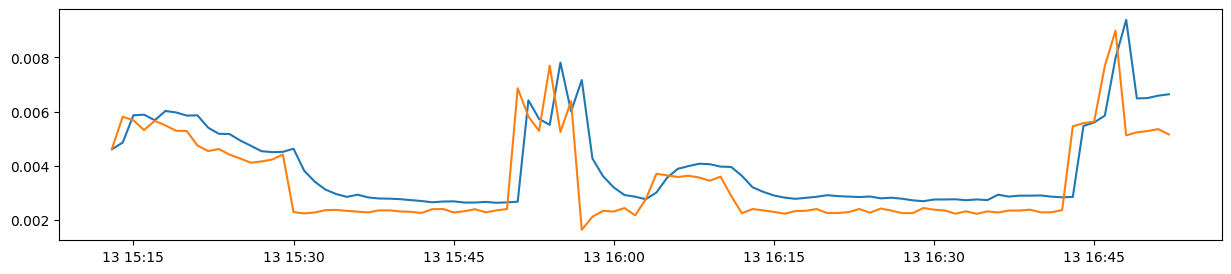

In [33]:
val_predictions= model_gen_lstm.predict(X_val).flatten()
y_val=y_val.ravel() #y_val in 1D-Array sonst: ValueError: Per-column arrays must each be 1-dimensional
val_results = pd.DataFrame(data={'Val Predictions':val_predictions,'Actuals':y_val})



# Rückgängig machen der Normalisierung
val_results['Val Predictions'] = val_results['Val Predictions'] * max_sum_kWh
val_results['Actuals'] = val_results['Actuals'] * max_sum_kWh

#Index anpassen
val_results.index = energy_df.index[500593:526938]


plt.figure(figsize=(15, 3))
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

val_results

1/1 [==============================] - 0s 14ms/step


,Test Predictions,Actuals
Time,,
2016-12-31 23:58:00,0.002203,0.002710
2016-12-31 23:59:00,0.002125,0.002742


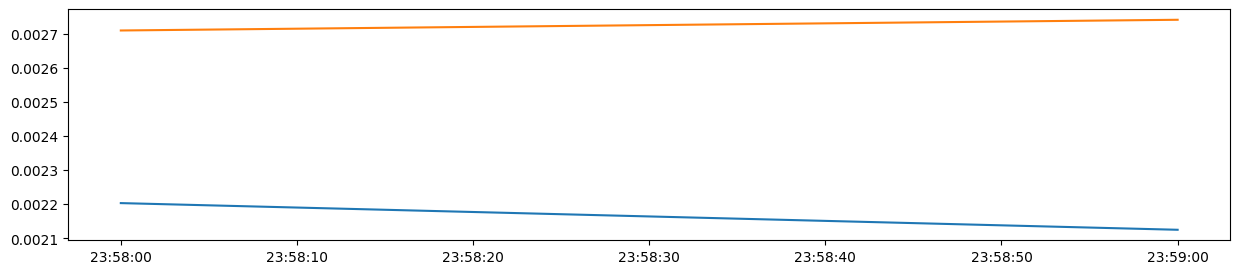

In [37]:
#Test= Endgültige Bewertung des Modells anhand völlig unbekannter Daten
test_predictions= model_gen_lstm.predict(X_test).flatten()
y_test=y_test.ravel() 
test_results = pd.DataFrame(data={'Test Predictions':test_predictions,'Actuals':y_test})

# Rückgängig machen der Normalisierung
test_results['Test Predictions'] = test_results['Test Predictions'] * max_sum_kWh
test_results['Actuals'] = test_results['Actuals'] * max_sum_kWh

#Index anpassen
test_results.index = energy_df.index[527038:]


plt.figure(figsize=(15, 3)) 

plt.plot(test_results['Test Predictions']) #[2400:2600]

plt.plot(test_results['Actuals']) #[2400:2600]

test_results

In [38]:
#Accuracy ausgeben 
test_loss, test_accuracy = model_gen_lstm.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


1/1 [==============================] - 0s 24ms/step - loss: 1.4245e-05 - MAE: 0.0038
Test Accuracy: 0.003756384365260601


In [39]:
# Berechnung des absoluten Fehlers
absolute_error = abs(test_results['Actuals'] - test_results['Test Predictions'])

# Berechnung des prozentualen Fehlers in Prozent
percentage_error = (absolute_error / test_results['Actuals']) * 100

# Durchschnittlichen prozentualen Fehler berechnen
average_percentage_error = percentage_error.mean()

# Genauigkeit berechnen (100% minus durchschnittlichen prozentualen Fehler)
accuracy = 100 - average_percentage_error

print(f'Genauigkeit: {accuracy:.2f}%')


Genauigkeit: 79.41%
